In [59]:
#import neccessary Libraries and modules
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [60]:
'''
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)
'''

'\n# Detect hardware, return appropriate distribution strategy\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    print(\'Running on TPU \', tpu.master())\nexcept ValueError:\n    tpu = None\n\nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nelse:\n    strategy = tf.distribute.get_strategy() \n    # default distribution strategy in Tensorflow. Works on CPU and single GPU.\n\nprint("REPLICAS: ", strategy.num_replicas_in_sync)\n'

In [61]:
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x601_y501_cla

In [62]:
# Two arrays holding images by class type

class0 = [] # 0 = idc-
class1 = [] # 1 = idc+

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [63]:
len(class0)

198738

In [64]:
len(class1)

78786

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
sampled_class0 = random.sample(class0, 10000)
sampled_class1 = random.sample(class1, 10000)
#len(sampled_class0)

In [67]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays


In [68]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [69]:
class0_array[1]

[array([[[218, 197, 233],
         [224, 212, 238],
         [219, 208, 235],
         ...,
         [206, 190, 231],
         [214, 197, 233],
         [207, 183, 230]],
 
        [[221, 211, 239],
         [220, 205, 234],
         [220, 204, 239],
         ...,
         [216, 196, 237],
         [197, 171, 226],
         [201, 173, 231]],
 
        [[215, 201, 235],
         [221, 205, 236],
         [225, 211, 234],
         ...,
         [219, 204, 235],
         [220, 203, 240],
         [216, 206, 235]],
 
        ...,
 
        [[225, 206, 235],
         [210, 195, 235],
         [224, 212, 237],
         ...,
         [206, 184, 232],
         [201, 180, 225],
         [217, 196, 236]],
 
        [[212, 192, 230],
         [239, 236, 244],
         [219, 206, 233],
         ...,
         [209, 186, 227],
         [225, 211, 241],
         [186, 156, 220]],
 
        [[211, 192, 235],
         [195, 169, 226],
         [203, 179, 228],
         ...,
         [213, 196, 232],
  

In [70]:
test = cv2.imread('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
test.shape

(50, 50, 3)

In [71]:
from keras.preprocessing.image import load_img, img_to_array

In [72]:
def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 25)
    i=0
    for loc in ind:
        plt.subplot(5,5,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

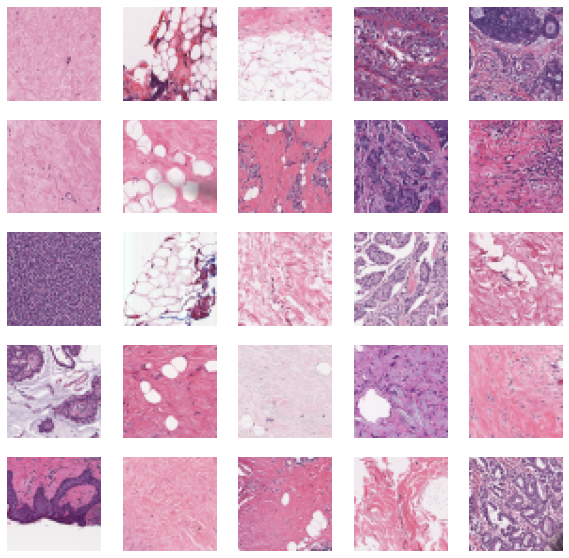

In [73]:
show_img(imagePatches)

In [74]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(combined_data)

In [75]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [76]:
# print(X[11].reshape(-1, 50, 50, 3))
# reshape X data
X = np.array(X).reshape(-1, 50, 50, 3)

In [77]:
#Determine Shape of X
X.shape

(20000, 50, 50, 3)

In [78]:
#Splitting data into train and test data sets
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test1, y_test1, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
print(X_train.shape, X_test.shape, X_val, y_train.shape, y_test.shape, y_val.shape)

(15000, 50, 50, 3) (3750, 50, 50, 3) [[[[225 221 242]
   [221 211 239]
   [215 196 238]
   ...
   [201 185 228]
   [197 174 228]
   [213 200 228]]

  [[227 221 241]
   [222 212 242]
   [217 209 237]
   ...
   [204 186 216]
   [215 200 236]
   [222 209 238]]

  [[232 216 240]
   [212 202 239]
   [220 209 239]
   ...
   [209 192 224]
   [215 199 234]
   [197 176 221]]

  ...

  [[244 243 244]
   [244 242 244]
   [243 242 244]
   ...
   [225 215 239]
   [213 200 238]
   [206 187 237]]

  [[243 242 244]
   [243 243 244]
   [243 243 244]
   ...
   [220 207 233]
   [228 219 242]
   [205 189 238]]

  [[243 242 244]
   [243 242 244]
   [243 242 244]
   ...
   [198 181 218]
   [207 191 233]
   [227 218 237]]]


 [[[194 178 232]
   [195 182 235]
   [185 162 231]
   ...
   [167 145 226]
   [180 161 229]
   [184 162 233]]

  [[214 197 235]
   [201 185 231]
   [166 142 226]
   ...
   [177 157 228]
   [183 163 227]
   [193 181 228]]

  [[196 175 232]
   [193 179 234]
   [184 162 235]
   ...
   [196 

In [79]:
#Crating a Convolutional Neural Network

def create_model():        
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(50,50,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    #binary_crossentropy is used as Cancer detecion is  binary classification model
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   

    return model

In [80]:
#with strategy.scope():
model = create_model()
#Training and Testing the CNN 
#epochs determines no of times learning algorithm walks through the dataset
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 20,
    verbose = 2,
)



Epoch 1/20
469/469 - 3s - loss: 0.8466 - accuracy: 0.8406 - val_loss: 0.4064 - val_accuracy: 0.8531
Epoch 2/20
469/469 - 2s - loss: 0.3373 - accuracy: 0.8746 - val_loss: 0.3161 - val_accuracy: 0.8715
Epoch 3/20
469/469 - 2s - loss: 0.2495 - accuracy: 0.9058 - val_loss: 0.3470 - val_accuracy: 0.8904
Epoch 4/20
469/469 - 2s - loss: 0.1957 - accuracy: 0.9309 - val_loss: 0.2980 - val_accuracy: 0.9051
Epoch 5/20
469/469 - 2s - loss: 0.1603 - accuracy: 0.9460 - val_loss: 0.2791 - val_accuracy: 0.9029
Epoch 6/20
469/469 - 2s - loss: 0.1159 - accuracy: 0.9641 - val_loss: 0.2843 - val_accuracy: 0.9096
Epoch 7/20
469/469 - 2s - loss: 0.0901 - accuracy: 0.9741 - val_loss: 0.3116 - val_accuracy: 0.9160
Epoch 8/20
469/469 - 2s - loss: 0.0631 - accuracy: 0.9821 - val_loss: 0.3200 - val_accuracy: 0.9195
Epoch 9/20
469/469 - 2s - loss: 0.0504 - accuracy: 0.9874 - val_loss: 0.3390 - val_accuracy: 0.9171
Epoch 10/20
469/469 - 2s - loss: 0.0392 - accuracy: 0.9894 - val_loss: 0.3952 - val_accuracy: 0.9179

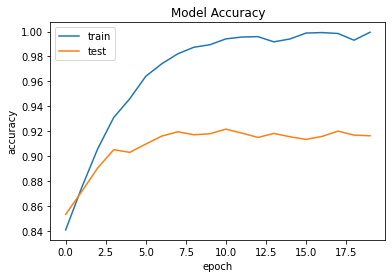

In [81]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

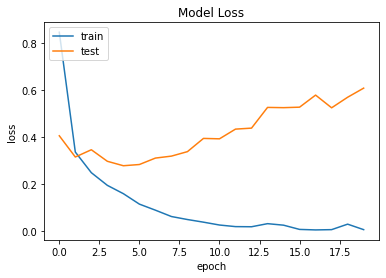

In [82]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train=np.argmax(y_train, axis=1)
    y_test=np.argmax(y_test, axis=1)
    y_val=np.argmax(y_val, axis=1)
    y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, y_train_pred)*100), "%")
    
    print("Val accuracy Score--------->")
    
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
  
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

Train accuracy Score------------>
99.993 %
Val accuracy Score--------->
90.400 %
Test accuracy Score--------->
91.627 %
F1 Score--------------->
91.245 %
Cohen Kappa Score------------->
66.051 %
Recall-------------->
91.627 %
Precision-------------->
91.192 %


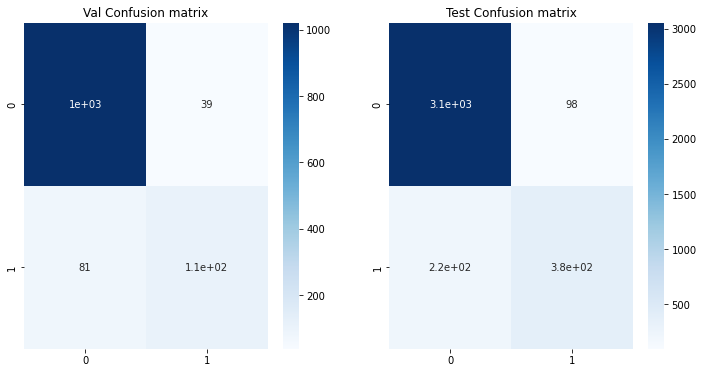

In [84]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)